目的変数が0または1の2値になる回帰：ロジスティック回帰

次の内容について学んで行きます。
```
1. ロジスティック関数の基本
2. その他の資料
3. データの準備
4. データの可視化
5. データの前処理
6. 多重共線性（Multicollinearity）について
7. scikit-learnを使ったロジスティック回帰
8. 学習とテスト
9. その他の話題
```

In [1]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame

import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

from sklearn import metrics

import statsmodels.api as sm

-----
## Part 1: 数学的な基礎

−∞から∞までの値を入力として受け取って、常に0から1の間の値を返す関数を考える。
これをロジスティック関数（シグモイド関数*）と呼ぶ。

式で書くと以下。
\begin{equation*}
\sigma(t) = \frac{1}{1 + e^{-t}}
\end{equation*}

*シグモイド関数は、ロジスティック関数の一種

グラフを描いてみる。

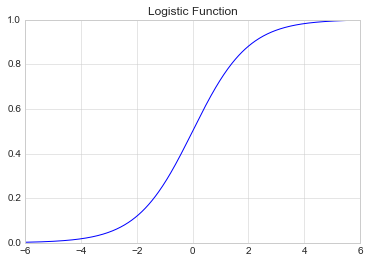

In [2]:
# ロジスティック関数
def logistic(t):
    return 1.0 / ( 1 + math.exp((-1.0) * t) )

# tを-6から6まで500点用意する
t = np.linspace(-6, 6, 500)

# リスト内包表記で、yを用意する
y = np.array([logistic(ele) for ele in t])

# プロットする
plt.plot(t, y)
plt.title('Logistic Function')

-----
## Part 2: その他の資料

* [技術評論社のページ](http://gihyo.jp/dev/serial/01/machine-learning/0018)
* [Andrew Ng's class notes（英語）](http://cs229.stanford.edu/notes/cs229-notes1.pdf): 16ページ目からがLogistic Regressionの解説
* [CMU notes（英語）](http://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch12.pdf)
* [Wikipedia（英語）](https://en.wikipedia.org/wiki/Logistic_regression)

-----
## Part 3: データの準備

今回使うサンプルデータ：http://www.statsmodels.org/stable/datasets/generated/fair.html

Statsmodelsの一部として提供されているもので、1974年に行われた、女性に対する調査。結婚している女性に対する、所謂不倫の有無を聞いた調査です。

論文：https://fairmodel.econ.yale.edu/rayfair/pdf/1978a200.pdf

自己申告なので、データに嘘が含まれる可能性は十分にある。
不倫の有無という点だけに注目して、このデータを使って、ロジスティック回帰について見ていく。

以下の問いに対する答えを探します。
```
それぞれの女性の属性から、不倫の有無を予測できるか？
```

### データの概要

```
Number of observations: 6366
Number of variables: 9
Variable name definitions:

    rate_marriage   : How rate marriage, 1 = very poor, 2 = poor, 3 = fair,
                    4 = good, 5 = very good
    age             : Age
    yrs_married     : No. years married. Interval approximations. See
                    original paper for detailed explanation.
    children        : No. children
    religious       : How relgious, 1 = not, 2 = mildly, 3 = fairly,
                    4 = strongly
    educ            : Level of education, 9 = grade school, 12 = high
                    school, 14 = some college, 16 = college graduate,
                    17 = some graduate school, 20 = advanced degree
    occupation      : 1 = student, 2 = farming, agriculture; semi-skilled,
                    or unskilled worker; 3 = white-colloar; 4 = teacher
                    counselor social worker, nurse; artist, writers;
                    technician, skilled worker, 5 = managerial,
                    administrative, business, 6 = professional with
                    advanced degree
    occupation_husb : Husband's occupation. Same as occupation.
    affairs         : measure of time spent in extramarital affairs

See the original paper for more details.
```

-----
## Part 4: データの可視化

In [23]:
# 以下のコードで、データをロードできる。fairがデータセットの名前だが、不倫を意味する英単語は'affair'
df = sm.datasets.fair.load_pandas().data

In [24]:
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


不倫の有無を0, 1で表現する新しい列「Had Affair」を作る。
affairsが0でなければ1、0ならそのままHad_Affairも0。

In [25]:
# 関数を作る
def affair_check(x):
    if x !=0:
        return 1
    else:
        return 0

# applyを使って、新しい列用のデータを作る
df['Had_Affair'] = df['affairs'].apply(affair_check)

In [8]:
df

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,Had_Affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1
5,4.0,27.0,9.0,0.0,2.0,14.0,3.0,4.0,4.666666,1
6,5.0,37.0,23.0,5.5,2.0,12.0,5.0,4.0,0.852174,1
7,5.0,37.0,23.0,5.5,2.0,12.0,2.0,3.0,1.826086,1
8,3.0,22.0,2.5,0.0,2.0,12.0,3.0,3.0,4.799999,1
9,3.0,27.0,6.0,0.0,1.0,16.0,3.0,5.0,1.333333,1


groupbyを使うと、簡単にグループ分けできる。

In [9]:
# 不倫の有無（Had_Affair列）でグループ分けする
df.groupby('Had_Affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
Had_Affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


この簡単な解析からは、不倫したことがある女性は、若干年齢が上で、比較的長く結婚しており、宗教観と学歴が少し低いことがわかる。
ただ、平均値はグループ間で似たような値になっている。

わかりやすいように可視化する。

まずはヒストグラムから。

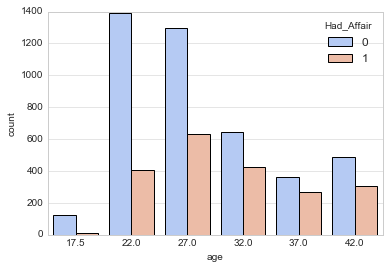

In [13]:
#　年齢分布
sns.countplot('age', data = df.sort_values('age'), hue = 'Had_Affair', palette = 'coolwarm')

年齢が上がると不倫率が上がる傾向が見られる。
では、結婚してからの年月はどうか？

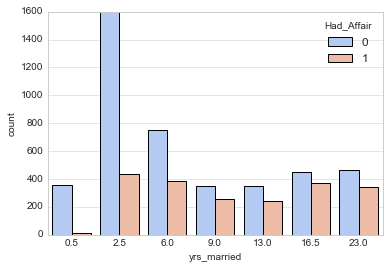

In [14]:
sns.countplot('yrs_married', data = df.sort_values('yrs_married'), hue = 'Had_Affair', palette = 'coolwarm')

子供の数は？

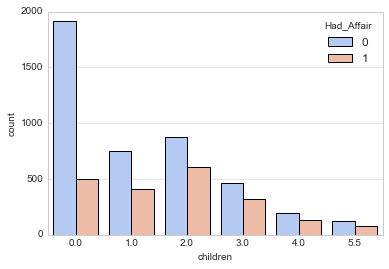

In [15]:
sns.countplot('children', data = df.sort_values('children'), hue = 'Had_Affair', palette = 'coolwarm')

子供の数が少ないと、不倫率が低い。

最後は学歴。

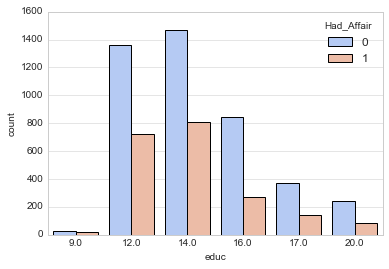

In [16]:
sns.countplot('educ', data = df.sort_values('educ'), hue = 'Had_Affair', palette = 'coolwarm')

-----
## Part 5: データの前処理

データを見ていると、2つだけ別の列と違う性質のものがある。Occupation と Husband's Occupation。
これはそれぞれ奥さんとご主人の職業だが、カテゴリー型のデータになっているので、数字の大小に意味がない。

このような変数は、ダミー変数を導入して、その変数の0/1で表現し直すことを考える。
pandasに便利な関数があるので、実際にやってみながら説明する。

In [18]:
# カテゴリーを表現する変数を、ダミー変数に展開
occ_dummies = pd.get_dummies(df['occupation'])
hus_occ_dummies = pd.get_dummies(df['occupation_husb'])

occ_dummies.head()

,1.0,2.0,3.0,4.0,5.0,6.0
0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0


In [20]:
# 列名をつける
occ_dummies.columns = ['occ1', 'occ2', 'occ3', 'occ4', 'occ5', 'occ6']
hus_occ_dummies.columns = ['hocc1', 'hocc2', 'hocc3', 'hocc4', 'hocc5', 'hocc6']

In [26]:
# 不要になったoccupationの列と、目的変数「Had_Affair」を削除
X = df.drop(['occupation', 'occupation_husb', 'Had_Affair'], axis = 1)

# ダミー変数のDataFrameを繋げる
dummies = pd.concat([occ_dummies, hus_occ_dummies], axis = 1)

In [27]:
X = pd.concat([X, dummies], axis = 1)

X.head()

,rate_marriage,age,yrs_married,children,religious,educ,affairs,occ1,occ2,occ3,occ4,occ5,occ6,hocc1,hocc2,hocc3,hocc4,hocc5,hocc6
0,3.0,32.0,9.0,3.0,3.0,17.0,0.111111,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.0,27.0,13.0,3.0,1.0,14.0,3.230769,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,4.0,22.0,2.5,0.0,1.0,16.0,1.400000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.0,37.0,16.5,4.0,3.0,16.0,0.727273,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5.0,27.0,9.0,1.0,1.0,14.0,4.666666,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [28]:
# Yに目的変数を格納
Y = df.Had_Affair

Y.head()

0    1
1    1
2    1
3    1
4    1
Name: Had_Affair, dtype: int64

-----
## Part 6: 多重共線性

ダミー変数同士は高度に相関する可能性がある。

例えば、男女を表現するのに、maleとfemaleのダミー変数を導入したとする。
maleが1ならfemaleは0、その逆も成り立つ。
このように、変数同士が互いに高い相関を示すことを、「多重共線性」と言う。
ダミー変数をすべて含めると、完全に相関する変数を回帰モデルに入れることになる。

ひとまず、ダミー変数からocc1とhocc1を取り除く。
affairs列も目的変数の元になっている変数なのでこれも削除する。

In [29]:
X = X.drop('occ1', axis = 1)
X = X.drop('hocc1', axis = 1)
X = X.drop('affairs', axis = 1)

X.head()

,rate_marriage,age,yrs_married,children,religious,educ,occ2,occ3,occ4,occ5,occ6,hocc2,hocc3,hocc4,hocc5,hocc6
0,3.0,32.0,9.0,3.0,3.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.0,27.0,13.0,3.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,4.0,22.0,2.5,0.0,1.0,16.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.0,37.0,16.5,4.0,3.0,16.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5.0,27.0,9.0,1.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [30]:
# 最後に、Yを1次元のarrayにする。
# np.ravelかY.valuesを使う

Y = Y.values
# Y = np.ravel(Y)
Y

array([1, 1, 1, ..., 0, 0, 0])

-----
## Part 7: ScikitLearnを使ったロジスティック回帰

いよいよ実際にロジスティック回帰を行う。前のレクチャーで学んだ、線形回帰に非常によく似ている。

In [31]:
# LogisticRegressionクラスのインスタンスを作る
log_model = LogisticRegression()

# データを使ってモデルを作る
log_model.fit(X, Y)

# モデルの制度を確認
log_model.score(X, Y)

0.72588752748978946

約73%の精度が実現できたように見える。

実際の目的変数Yの平均値を計算する。

In [32]:
# numpyのarrayなので、平均をすぐに計算できる。
Y.mean()

0.32249450204209867

これは、作ったモデルが「不倫していない（つまり0）」と出力すると、1 -  0.32 = 0.68となり、68%の精度が得られることになる（？）

どの変数が予測に寄与しているのか見ていく。

In [33]:
# 変数名とその係数を格納するDataFrameを作る
coeff_df = DataFrame([X.columns, log_model.coef_[0]]).T
coeff_df

,0,1
0,rate_marriage,-0.697845
1,age,-0.0563368
2,yrs_married,0.103893
3,children,0.0181854
4,religious,-0.368507
5,educ,0.00864804
6,occ2,0.298119
7,occ3,0.60815
8,occ4,0.346511
9,occ5,0.942259


（コピペ）

marriage ratingが増えると、不倫の可能性は減少します。 宗教観（religiousness）が高くなると、同様に不倫の可能性は減少するようです。
ダミー変数は、学生を示す1の変数を取り除いているので、そこが基準となっていることを頭に入れておく必要がありますが、大きな値になっていれば、その職業に就いている場合に、不倫率が上がる傾向にあることは見て取れます。実際に、可視化してみるとわかります。

---
## Part 8: 学習とテスト

線形回帰のレクチャーでやったのと同じように、データを学習用とテスト用に分けて、モデルの性能を確認してみる。

In [39]:
# おなじく、train_test_splitを使う。
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

# 新しいモデルを作る
log_model2 = LogisticRegression()

In [36]:
# 学習用のデータだけでモデルを当てはめる
log_model2.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [38]:
# predictメソッドで予測
# テスト用データで予測
class_predict = log_model2.predict(X_test)

# 精度を計算する
print(metrics.accuracy_score(Y_test, class_predict))

0.727386934673


約72％の精度。これは、すべてのデータを使ったときとだいたい同じ。

-----
## Part 9: 結論とその他の話題

（コピペ）

ロジスティック回帰を使ってモデルを作り、データをもとに予測する方法を学びました。数学的な詳細は説明しませんでしたので、興味のある方は是非挑戦してみてください。
機械学習アルゴリズムの精度を上げる方法論が、いろいろと検討されています。 例えば、正則化は、モデルを出来るだけシンプルにすることで精度を上げようとする方法です。

* [正則化（Wikipedia）](https://ja.wikipedia.org/wiki/%E6%AD%A3%E5%89%87%E5%8C%96)
* [Regularization (mathematics)(Wikipedia英語)](https://en.wikipedia.org/wiki/Regularization_%28mathematics%29#Regularization_in_statistics_and_machine_learning)

その他、ロジスティック回帰に関する資料リンク：
* [Statsmodelsを使ったロジスティック回帰の解説 (yhat)](http://blog.yhat.com/posts/logistic-regression-and-python.html)
* [scikit-learnの公式ドキュメント](http://scikit-learn.or g/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* [米国で最近増えているデータ解析を生業とする会社（DataRobot）のページ](https://www.datarobot.com/blog/classification-with-scikit-learn/)
* [数学的背景も考慮に入れた解説](http://aimotion.blogspot.jp/2011/11/machine-learning-with-python-logistic.html)